![Imagen](itd.png)

# Analisis De Datos Masivos
## Práctica de laboratorio Detección de anomalías en medidores de Internet
    
## Nombre Del Docente
### Jose Gabriel Rodriguez Rivas
    
## Francisco javier Favela Najera 

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('rpi_data_processed.csv')

# Initialize dataframe df_rates
df_rates = df.drop(['Ping (ms)', 'Date', 'Time'], axis=1)

# Rename the download and
# upload columns of df_rates
lookup = {'Download (Mbit/s)': 'download_rate', 
          'Upload (Mbit/s)': 'upload_rate'}
df_rates = df_rates.rename(columns = lookup)

# Calculate ping_rate
ping_rate = 1. / df['Ping (ms)']

# Convert ping_rate to 1/seconds
ping_rate = 1000. * ping_rate

# Add a column to complete the task
df_rates['ping_rate'] = ping_rate

In [3]:
df_rates.describe()

,download_rate,upload_rate,ping_rate
count,672.000000,672.000000,672.000000
mean,90.456295,13.696815,48.662648
std,3.463351,1.081080,6.033436
min,58.480000,6.210000,13.067113
25%,90.220000,13.640000,45.792264
50%,91.565000,13.980000,49.212599
75%,92.070000,14.180000,52.319042
max,92.870000,14.550000,61.854395


In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

In [5]:
def scatter_view(x, y, z, azim, elev):
    # Init figure and axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)
    
    # Compute scatter plot
    ax.scatter(x, y, z)
    ax.set_xlabel('D rate (Mbit/s)', fontsize=16)
    ax.set_ylabel('U rate (Mbit/s)', fontsize=16)
    ax.set_zlabel('P rate (1/s)', fontsize=16)
    
    # Specify azimuth
    # and elevation
    ax.azim = azim
    ax.elev = elev

In [6]:
xi = df_rates['download_rate']
yi = df_rates['upload_rate']
zi = df_rates['ping_rate']
interact(lambda azim, elev: scatter_view(xi, yi, zi, azim, elev),
         azim=(0, 90), elev=(0, 90))

interactive(children=(IntSlider(value=45, description='azim', max=90), IntSlider(value=45, description='elev',…

<function __main__.<lambda>(azim, elev)>

In [7]:
mu = df_rates.mean()

In [10]:
euclid_sq = np.square(df_rates - mu).sum(axis=1)
euclid = np.sqrt(euclid_sq)

Text(0, 0.5, 'Relative frequency')

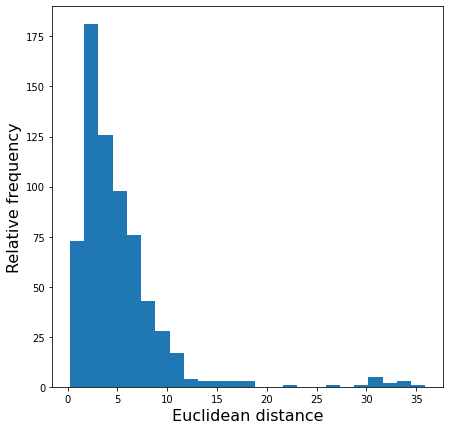

In [12]:
fig = plt.figure(figsize=(7, 7))
plt.hist(euclid,25)
plt.xlabel('Euclidean distance', fontsize=16)
plt.ylabel('Relative frequency', fontsize=16)

In [13]:
max_euclid = euclid.max() # Maximum Euclidean distance
nmd_euclid = [float(x)/max_euclid for x in euclid] # Normalized Euclidean distance

In [14]:
nmd_euclid

[0.3262224463653791,
 0.22928610303261934,
 0.8528540203720665,
 0.09449072836562625,
 0.12578471999417434,
 0.23230456737372585,
 0.09373031086032767,
 0.046364748389123744,
 0.0896571269016544,
 0.06308707655158527,
 0.11811509506615198,
 0.19134930144025333,
 0.18417427593102267,
 0.1766999865125587,
 0.1692969549475325,
 0.2161308716768454,
 0.10428501156230449,
 0.032055218028910044,
 0.08957613367392393,
 0.48069963353737044,
 0.1042554625803224,
 0.09008487013122123,
 0.09133768360751264,
 0.05259504483291159,
 0.27134111900043945,
 0.06545420771097757,
 0.04401165705964209,
 0.3218716372978939,
 0.03485480584782702,
 0.1278253995506857,
 0.16578470394150682,
 0.10761672649606978,
 0.1394448037066203,
 0.22595593568242042,
 0.1255194104606127,
 0.24573839038907114,
 0.13378861509600087,
 0.12809667317965784,
 0.1103549508232206,
 0.13250028964607413,
 0.05990783399186634,
 0.15212863744372404,
 0.14827601148131286,
 0.20871693043657033,
 0.14099179980866688,
 0.05986443586215856

In [18]:
ecl_alarm_rate = []
nmd_range = np.linspace(0, 1, 400)
for nmd_decision in nmd_range:
    num_fail=(nmd_euclid>nmd_decision).sum()
    ecl_alarm_rate.append(float(num_fail)/len(euclid))

Text(0, 0.5, 'Alarm rate')

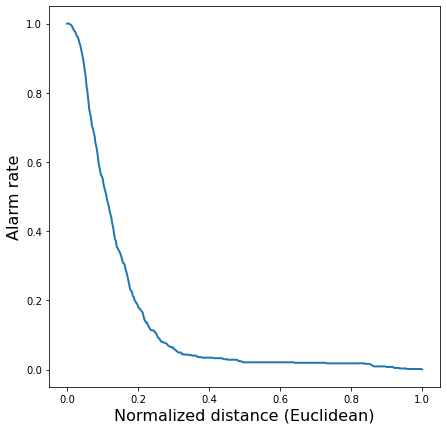

In [19]:
fig = plt.figure(figsize=(7, 7))
plt.plot(nmd_range, ecl_alarm_rate, linewidth=2)
plt.xlabel('Normalized distance (Euclidean)', fontsize=16)
plt.ylabel('Alarm rate', fontsize=16)

In [21]:
threshold = 0.1
index,ecl_threshold = next(tlp for tlp in enumerate(ecl_alarm_rate) if tlp[1]< threshold)
ecl_decision = nmd_range[index]

Text(0, 0.5, 'Alarm rate')

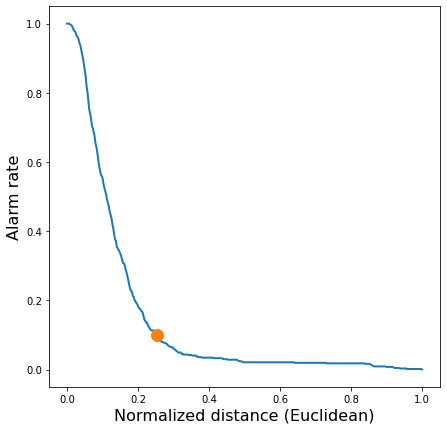

In [29]:
fig = plt.figure(figsize=(7, 7))
plt.plot(nmd_range, ecl_alarm_rate, linewidth=2)
plt.plot(ecl_decision,ecl_threshold,'o',markersize=12)
plt.xlabel('Normalized distance (Euclidean)', fontsize=16)
plt.ylabel('Alarm rate', fontsize=16)

In [30]:
radius = ecl_decision * max_euclid
phi = np.linspace(0, 2 * np.pi, 300)
theta = np.linspace(0, np.pi, 300)

# Decision sphere (Cartesian coordinates)
xs = radius * np.outer(np.sin(theta), np.cos(phi))
ys = radius * np.outer(np.sin(theta), np.sin(phi))
zs = radius * np.outer(np.cos(theta), np.ones(np.size(phi)))

# Centre decision sphere at mean
ecl_xd = xs + df_rates['download_rate'].mean()
ecl_yd = ys + df_rates['upload_rate'].mean()
ecl_zd = zs + df_rates['ping_rate'].mean()

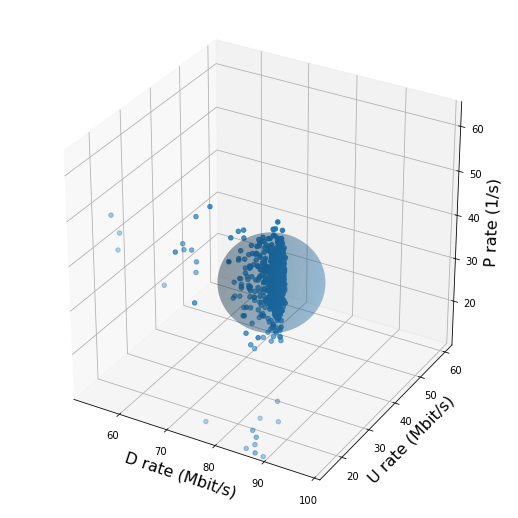

In [31]:
fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig)

# Plot data
ax.scatter(df_rates['download_rate'],
           df_rates['upload_rate'], 
           df_rates['ping_rate'])

# Plot decision boundary
ax.plot_surface(ecl_xd, ecl_yd, ecl_zd,
                linewidth=0, alpha=0.25)

# Label axes
ax.set_xlabel('D rate (Mbit/s)', fontsize=16)
ax.set_ylabel('U rate (Mbit/s)', fontsize=16)
ax.set_zlabel('P rate (1/s)', fontsize=16)
    
# --------------------------------------------------
# Set equal aspect ratio for all axes
# --------------------------------------------------

# Extreme values of x, y, z
extremes = []
extremes.append([df_rates['download_rate'].min(),
                 df_rates['download_rate'].max()])
extremes.append([df_rates['upload_rate'].min(),
                 df_rates['upload_rate'].max()])
extremes.append([df_rates['ping_rate'].min(),
                 df_rates['ping_rate'].max()])

# Half-widths and mid-points
hwidths = [(row[1] - row[0]) / 2.0 for row in extremes]
midpts = [(row[1] + row[0]) / 2.0 for row in extremes]

# Set xlim, ylim, zlim
left_ends = midpts - np.max(hwidths)
right_ends = midpts + np.max(hwidths)
ax.set_xlim([left_ends[0], right_ends[0]]);
ax.set_ylim([left_ends[1], right_ends[1]]);
ax.set_ylim([left_ends[2], right_ends[2]]);